# SuperflexPy example 10: Implement M02 of Dal Molin et al., 2020

Author: Marco Dal Molin

Collaborators: Fabrizio Fenicia, Dmitri Kavetski

## What's in this example

This example will cover the following aspects:
- [Reproduce the semi distributed model M02 presented in Dal Molin et al., 2020](https://superflexpy.readthedocs.io/en/latest/case_studies.html#dal-molin-et-al-2020-hess)

By clicking on the items you will be redirected to the documentation page (when available) that explains the arguments in a more detailed way. 

REFERENCE: Dal Molin, M., Schirmer, M., Zappa, M., and Fenicia, F.: Understanding dominant controls on streamflow spatial variability to set up a semi-distributed hydrological model: the case study of the Thur catchment, Hydrol. Earth Syst. Sci., 24, 1319–1345, https://doi.org/10.5194/hess-24-1319-2020, 2020.

## What's not in this example

The following aspects are already covered in other examples:

- [Initialize a complete model](./06_init_complete_model.ipynb)
- [Run the model](./01_run_simple_model.ipynb)
- [Change states and parameters](./01_run_simple_model.ipynb)

For this reason we will put only the code need, without further explanations. You can check the other examples by clicking on the items above.

## Do you want to use this example as a script?

Examples of SuperflexPy are created and distributed using Jupyter notebooks because they enable to conjugate runnable code with text explanations. We have decided to not provide the content of the notebooks as script because this would mean duplicating the same content in multiple places, bringing to maintainability problems.

If the user wants to download the content of this notebook as a python script, it is possible following the steps:
1. If not already done, open this notebook using [Binder](https://mybinder.org/v2/gh/dalmo1991/superflexPy/master?filepath=examples%2F10_Thur_M2.ipynb)
2. Go on File -> Download as -> Python (.py)
3. Select the saving path

The result is a Python script that contains all the markdown text as comment and the code contained inside the cells.

## STEP 1: Initialize the model

The model M4 is composed by 2 elements in series: an unsaturated reservoir and a fast reservoir. Both elements have already been implemented and can be imported from `superflexpy.implementation.elements.thur_model_hess`.

In [1]:
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag
from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

solver = PegasusPython()
approximator = ImplicitEulerPython(root_finder=solver)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=approximator,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)

unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 50.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=approximator,
    id='unsaturated'
)

lower_splitter = Splitter(
    direction=[
        [0],
        [0]
    ],
    weight=[
        [0.3],   # Portion to slow reservoir
        [0.7]    # Portion to fast reservoir
    ],
    id='lower-splitter'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 2.0},
    states={'lag': None},
    id='lag-fun'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 3.0},
    states={'S0': 0.0},
    approximation=approximator,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=approximator,
    id='slow'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

consolidated = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='consolidated'
)

unconsolidated = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='unconsolidated'
)

andelfingen = Node(
    units=[consolidated, unconsolidated],
    weights=[0.24, 0.76],
    area=403.3,
    id='andelfingen'
)

appenzell = Node(
    units=[consolidated, unconsolidated],
    weights=[0.92, 0.08],
    area=74.4,
    id='appenzell'
)

frauenfeld = Node(
    units=[consolidated, unconsolidated],
    weights=[0.49, 0.51],
    area=134.4,
    id='frauenfeld'
)

halden = Node(
    units=[consolidated, unconsolidated],
    weights=[0.34, 0.66],
    area=314.3,
    id='halden'
)

herisau = Node(
    units=[consolidated, unconsolidated],
    weights=[0.88, 0.12],
    area=16.7,
    id='herisau'
)

jonschwil = Node(
    units=[consolidated, unconsolidated],
    weights=[0.9, 0.1],
    area=401.6,
    id='jonschwil'
)

mogelsberg = Node(
    units=[consolidated, unconsolidated],
    weights=[0.92, 0.08],
    area=88.1,
    id='mogelsberg'
)

mosnang = Node(
    units=[consolidated],
    weights=[1.0],
    area=3.1,
    id='mosnang'
)

stgallen = Node(
    units=[consolidated, unconsolidated],
    weights=[0.87, 0.13],
    area=186.6,
    id='stgallen'
)

waengi = Node(
    units=[consolidated, unconsolidated],
    weights=[0.63, 0.37],
    area=78.9,
    id='waengi'
)

model = Network(
    nodes=[
        andelfingen,
        appenzell,
        frauenfeld,
        halden,
        herisau,
        jonschwil,
        mogelsberg,
        mosnang,
        stgallen,
        waengi,
    ],
    topology={
        'andelfingen': None,
        'appenzell': 'stgallen',
        'frauenfeld': 'andelfingen',
        'halden': 'andelfingen',
        'herisau': 'halden',
        'jonschwil': 'halden',
        'mogelsberg': 'jonschwil',
        'mosnang': 'jonschwil',
        'stgallen': 'halden',
        'waengi': 'frauenfeld',
    }
)

## STEP 2: Run the model

Now that the mode has been initialized, it can be run. This can be done running the code in the following cell.

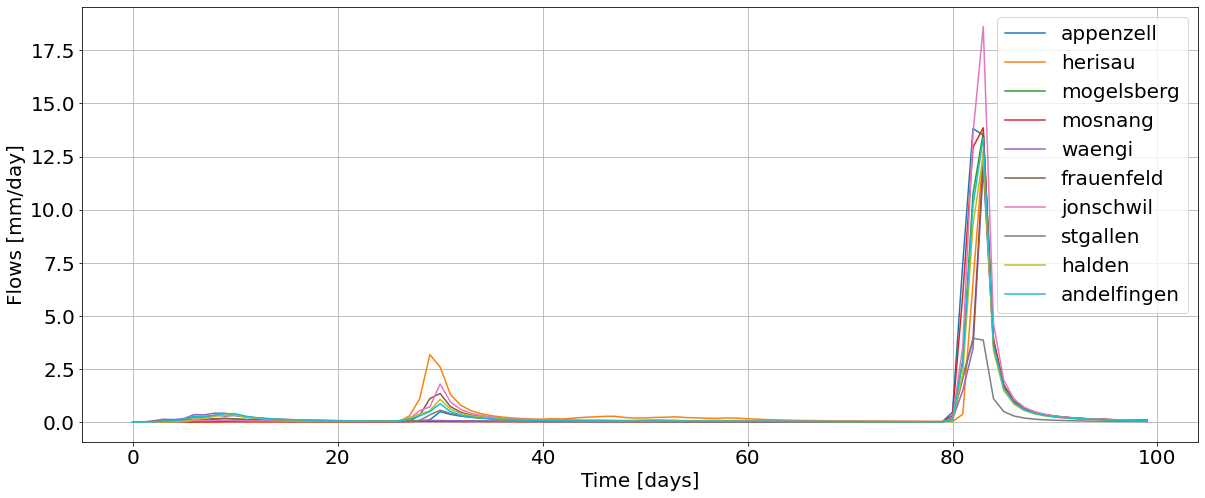

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

# Fix the seed
SEED = 2
rng = np.random.RandomState(seed=SEED)

catchments = [
    andelfingen,
    appenzell,
    frauenfeld,
    halden,
    herisau,
    jonschwil,
    mogelsberg,
    mosnang,
    stgallen,
    waengi
]

for cat in catchments:
    # Generate the input
    P = np.zeros(100)
    P[:10] = rng.randint(10, size=10)
    P[25:30] = rng.randint(20, size=5)
    P[40:60] = rng.randint(5, size=20)
    P[80:83] = rng.randint(30, 50, size=3)
    E = np.ones_like(P) * 2.0 # We use a constant PET
    T = (rng.rand(100) - 0.2) * 20
    cat.set_input([P, T, E])

# Set the timestep
model.set_timestep(1.0)

# Run the model
model.reset_states()
output = model.get_output()

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
for cat in output:
    ax.plot(np.arange(len(P)), output[cat][0], label=cat)

ax.set_xlabel('Time [days]')
ax.set_ylabel('Flows [mm/day]')
ax.legend()
ax.grid(True)